# Problem Set 2 
*Author: Saenko*

---

This assignment will introduce you to:
1. Basic functionality in PyTorch
2. Building and training a convolutional network
3. Visualizations using Tensorboard (optional)

This code has been tested on Colab. You may want to run parts of it on a GPU.
**Warning:** If you use the SCC, the gpu queue may be long when the deadline comes. Please start your homework early.

---


# Problem 0: Tutorials
This homework will introduce you to [PyTorch](https://pytorch.org), currently the fastest growing deep learning library.

Before starting the homework, please go over these introductory tutorials on the PyTorch webpage:

*   [60-minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
 

---



# Problem 1: Torch Intro (30 points)
The `torch.Tensor` class is the basic building block in PyTorch and is used to hold data and parameters. The `autograd` package provides automatic differentiation for all operations on Tensors. After reading about Autograd in the tutorials above,  we will implement a few simple examples of what Autograd can do.

In [1]:
import torch

### 1.1. Simple function
 Use `autograd` to do backpropagation on the simple function we saw in lecture, $f=(x+y)*z$. 

**1.1.1** Create the three inputs with values $x=-2$, $y=5$ and $z=-4$ as tensors and set `requires_grad=True` to track computation on them.



In [2]:
x = torch.tensor([-2.], requires_grad=True)
y = torch.tensor([5.], requires_grad=True)
z = torch.tensor([-4.], requires_grad=True)
print(x, y, z)

tensor([-2.], requires_grad=True) tensor([5.], requires_grad=True) tensor([-4.], requires_grad=True)


**1.1.2** Compute the $q=x+y$ and $f=q \times z$ functions, creating tensors for them in the process. Print out $q,f$, then run `f.backward(retain_graph=True)`, to compute the gradients w.r.t. $x,y,z$. The `retain_graph` attribute tells autograd to keep the computation graph around after backward pass as opposed deleting it (freeing some memory). Print the gradients. Note that the gradient for $q$ will be `None` since it is an intermediate node, even though `requires_grad` for it is automatically set to `True`. To access gradients for intermediate nodes in PyTorch you can use hooks as mentioned in [this answer](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/2). Compute the values by hand (or check the slides) to verify your solution.

In [3]:
def extract(x):
    global k
    k = x

q = x + y
f = q * z
print(q, f)

q.register_hook(extract)
f.backward(retain_graph=True)

print(x.grad, y.grad, z.grad, k.grad)


tensor([3.], grad_fn=<AddBackward0>) tensor([-12.], grad_fn=<MulBackward0>)
tensor([-4.]) tensor([-4.]) tensor([3.]) None


**1.1.3** If we now run `backward()` again, it will add the gradients to their previous values. Try it by running the above cell multiple times. This is useful in some cases, but if we just wanted to re-compute the gradients again, we need to zero them first, then run `backward()`. Add this step, then try running the  backward function multiple times to make sure the answer is the same each time!

In [4]:
x.grad.data.zero_()
y.grad.data.zero_()
z.grad.data.zero_()

f.backward(retain_graph=True)

print(x.grad, y.grad, z.grad, k.grad)

tensor([-4.]) tensor([-4.]) tensor([3.]) None


### 1.2 Neuron
 Implement the function corresponding to one neuron (logistic regression unit) that we saw in the lecture and compute the gradient w.r.t. $x$ and $w$. The function is $f=\sigma(w^Tx)$ where $\sigma()$ is the sigmoid function. Initialize $x=[-1, -2, 1]$ and the weights to $w=[2, -3, -3]$ where $w_3$ is the bias. Print out the gradients and double check their values by hand.

In [5]:
x = torch.tensor([-1., -2., 1.], requires_grad=True)
w = torch.tensor([2., -3., -3.], requires_grad=True)
print("x =", x)
print("w =", w)
f = torch.dot(w, x)
f = torch.sigmoid(f)
print("f(x, w) =", f)
f.backward()
print("The gradient of f() w.r.t. x is", x.grad)
print("The gradient of f() w.r.t. w is", w.grad)

x = tensor([-1., -2.,  1.], requires_grad=True)
w = tensor([ 2., -3., -3.], requires_grad=True)
f(x, w) = tensor(0.7311, grad_fn=<SigmoidBackward>)
The gradient of f() w.r.t. x is tensor([ 0.3932, -0.5898, -0.5898])
The gradient of f() w.r.t. w is tensor([-0.1966, -0.3932,  0.1966])


### 1.3. torch.nn
 We will now implement the same neuron function $f$ with the same variable values as in Q1.2, but using the `Linear` class from `torch.nn`, followed by the [Sigmoid](https://pytorch.org/docs/stable/nn.html#torch.nn.Sigmoid) class. In general, many useful functions are already implemented for us in this package. Compute the gradients $\partial f/\partial w$ by running `backward()` and print them out (they will be stored in the Linear variable, e.g. in `.weight.grad`.) 

In [6]:
m = torch.nn.Linear(2, 1)
m.weight.data = torch.tensor([[2., -3.]])
m.bias.data = torch.tensor([[-3.]])

print("weights:", m.weight)
print("\nbias", m.bias)

x = torch.tensor([[-1., -2.]], requires_grad=True)

f = m(x)

f = torch.sigmoid(f)
print("\nf:", f)
f.backward()
print("The gradient of f() w.r.t. w is", m.weight.grad, m.bias.grad)


weights: Parameter containing:
tensor([[ 2., -3.]], requires_grad=True)

bias Parameter containing:
tensor([[-3.]], requires_grad=True)

f: tensor([[0.7311]], grad_fn=<SigmoidBackward>)
The gradient of f() w.r.t. w is tensor([[-0.1966, -0.3932]]) tensor([[0.1966]])


### 1.4. Module
 Now lets put these two functions (Linear and Sigmoid) together into a "module". Read the [Neural Networks tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) if you have not already.

**1.4.1** This code makes a subclass of the `Module` class, called `Neuron`, and sets variables to the same values as above. 



In [7]:
import torch.nn as nn

class Neuron(nn.Module):

    def __init__(self):
        super(Neuron, self).__init__()
        # an affine operation: y = weight*x + bias, with fixed parameters
        self.linear = nn.Linear(2, 1)
        self.linear.weight.data = torch.tensor([[ 2., -3.]])
        self.linear.bias.data = torch.tensor([-3.])
        # a sigmoid function, elementwise
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

**1.4.2** Now create a  variable of your `Neuron` class called `my_neuron` and run backpropagation on it. Print out the gradients again. Make sure you zero out the gradients first, by calling `.zero_grad()` function of the parent class. Even if you will not re-compute the backprop, it is good practice to do this every time to avoid accumulating gradient!

In [8]:
my_neuron = Neuron()
print(my_neuron)

net = my_neuron(x)

params = list(my_neuron.parameters())
print("The weights are:", params[0])

print("\nf(x, w) =", net)

my_neuron.zero_grad()
net.backward()
print("The gradient of f() w.r.t. w is", my_neuron.linear.weight.grad , my_neuron.linear.bias.grad)


Neuron(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
The weights are: Parameter containing:
tensor([[ 2., -3.]], requires_grad=True)

f(x, w) = tensor([[0.7311]], grad_fn=<SigmoidBackward>)
The gradient of f() w.r.t. w is tensor([[-0.1966, -0.3932]]) tensor([0.1966])


### 1.5. Loss and SGD
 Now, lets train our neuron on some data. The code below creates a toy dataset containing a few inputs $x$ and outputs $y$ (a binary 0/1 label), as well as a function that plots the data and current solution.

w0 = 2.0 w1 = -3.0 bias = -3.0


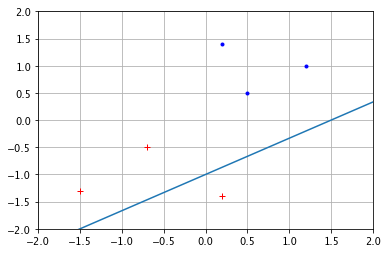

In [9]:
import matplotlib.pyplot as plt

# create some toy 2-D datapoints with binary (0/1) labels
x = torch.tensor([[1.2, 1], [0.2, 1.4], [0.5, 0.5], 
                  [-1.5, -1.3], [0.2, -1.4], [-0.7, -0.5]])
y = torch.tensor([0, 0, 0, 1, 1, 1 ])

def plot_soln(x, y, params):
  plt.plot(x[y==1,0], x[y==1,1], 'r+')
  plt.plot(x[y==0,0], x[y==0,1], 'b.')
  plt.grid(True)
  plt.axis([-2, 2, -2, 2])
  
  # NOTE : This may depend on how you implement Neuron.
  #   Change accordingly
  w0 = params[0][0][0].item()
  w1 = params[0][0][1].item()
  bias = params[1][0].item()
  
  print("w0 =", w0, "w1 =", w1, "bias =", bias)
  dbx = torch.tensor([-2, 2])
  dby = -(1/w1)*(w0*dbx + bias)  # plot the line corresponding to the weights and bias
  plt.plot(dbx, dby)

params = list(my_neuron.parameters())
plot_soln(x, y, params)

**1.5.1** Declare an object `criterion` of type `nn.CrossEntropyLoss`. Note that this can be called as a function on two tensors, one representing the network outputs and the other, the targets that the network is being trained to predict, to return the loss. Print the value of the loss on the dataset using the initial weights and bias defined above in Q1.2.

In [10]:
my_neuron = Neuron()
y_pred = my_neuron.forward(x)

y_pred = torch.cat([y_pred, 1 - y_pred], dim=1)

criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, y)
print("loss =", loss.item())

loss = 0.9425851702690125


**1.5.2** The following prints out the chain of `grad_fn` functions backwards starting from `loss.grad_fn`  to demonstrate what backpropagation will be run on.

In [11]:
print(loss.grad_fn)  
print(loss.grad_fn.next_functions[0][0])  
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])  

**1.5.3** Run the Stochastic Gradient Descent (SGD) optimizer from the `torch.optim` package to train your classifier on the toy dataset. Use the entire dataset in each batch. Use a learning rate of $0.01$ (no other hyperparameters). You will need to write a training loop that uses the `.step()` function of the optimizer. Plot the solution and print the loss after 1000 iterations.

loss = 0.870725691318512
w0 = 2.161842107772827 w1 = -2.233754873275757 bias = -3.3213229179382324


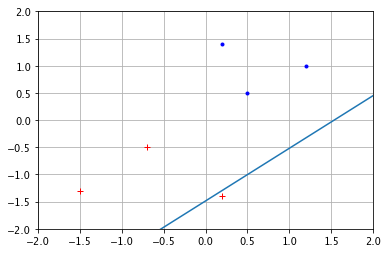

In [12]:
optimiser = torch.optim.SGD(my_neuron.parameters(), lr = 0.01)

for i in range(1000):
    optimiser.zero_grad()
    output = my_neuron(x)
    output = torch.cat([output, 1 - output], dim=1)
    loss = criterion(output, y)
    loss.backward()
    optimiser.step()

print("loss =", loss.item())
params = list(my_neuron.parameters())
plot_soln(x, y, params)

# i = 0
# accuracy = 0
# while accuracy != 1:
#     optimiser.zero_grad()
#     output = my_neuron(x)
#     output = torch.cat([output, 1 - output], dim=1)
#     score, predicted = torch.max(output, 1)

#     accuracy = (y == predicted).sum().float() / len(y)

#     loss = criterion(output, y)
#     loss.backward()
#     optimiser.step()
#     i = i + 1

# print("Number of iterations to learn the data: ", i)

**1.5.4** How many thousands of iterations does it take (approximately) until the neuron learns to classify the data correctly?

Around about 4723 iterations



---


# Problem 2: Convolutional Networks (30 points)

In this part, we will experiment with CNNs in PyTorch. You will need to read the documentation of the functions provided below to understand how they work.

**GPU Training.** Smaller networks will train fine on a CPU, but you may want to use GPU training for this part of the homework. You can run your experiments on Colab's GPUs or on BU's  [Shared Computing Cluster (SCC)](http://www.bu.edu/tech/services/research/computation/scc/). 

### 2.1. Training a CNN on SVHN
We will create and train a convolutional network on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of photos of house numbers, collected automatically using Google's Street View. Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. Google’s Street View imagery contains hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. Below are example images from the dataset. Note that for this dataset, each image (32x32 pixels) has been cropped around a single number in its center, which is the number we want to classify.

![SVHN images](http://ufldl.stanford.edu/housenumbers/32x32eg.png)


### 2.1.2 Data Download
The following downloads the SVHN dataset using `torchvision` and displays the images in the first batch. 

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.SVHN(root='./data', split='test',
                                        transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


    1     9     2     5


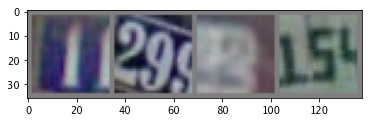

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2.1.3. CNN Model
Next, we will train a CNN on the data. We have defined a simple CNN for you with two convolutional layers and two fully-connected layers below.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)   # flatten features

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Instantiate the cross-entropy loss `criterion`, and an SGD optimizer from the `torch.optim` package with learning rate $.001$ and momentum $.9$. You may also want to enable GPU training using `torch.device()`.

In [16]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2.1.4 Training
Write the training loop that makes two full passes through the dataset (two epochs) using SGD. Your batch size should be 4.

Go slack off for a while...

![reddit xkcd comic](https://i.redd.it/5cjdqxcg07k11.png)

In [17]:
for epoch in range(2):
    for batch_index, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        optimiser.zero_grad()
        output = net(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimiser.step()

        if batch_index % 1000 == 0:
            print("Training epoch: {}, batch_index: {}, loss: {}".format(epoch, batch_index, loss.item()))



Training epoch: 0, batch_index: 0, loss: 2.326730728149414
Training epoch: 0, batch_index: 1000, loss: 2.0577826499938965
Training epoch: 0, batch_index: 2000, loss: 1.9450044631958008
Training epoch: 0, batch_index: 3000, loss: 2.3611228466033936
Training epoch: 0, batch_index: 4000, loss: 1.8280805349349976
Training epoch: 0, batch_index: 5000, loss: 1.2226778268814087
Training epoch: 0, batch_index: 6000, loss: 0.8556358814239502
Training epoch: 0, batch_index: 7000, loss: 0.0741531252861023
Training epoch: 0, batch_index: 8000, loss: 1.0715937614440918
Training epoch: 0, batch_index: 9000, loss: 1.6796863079071045
Training epoch: 0, batch_index: 10000, loss: 1.5784956216812134
Training epoch: 0, batch_index: 11000, loss: 0.08296669274568558
Training epoch: 0, batch_index: 12000, loss: 0.7492615580558777
Training epoch: 0, batch_index: 13000, loss: 0.2027430236339569
Training epoch: 0, batch_index: 14000, loss: 1.374398112297058
Training epoch: 0, batch_index: 15000, loss: 0.6298038

### 2.1.5 Test Accuracy
Load the test data (don't forget to move it to GPU if using). Make predictions on it using the trained network and compute the accuracy. You should see an accuracy of around 84%.

In [18]:
correct = 0

for data, target in testloader:
    data, target = data.to(device), target.to(device)

    output = net(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

accuracy = 100. * correct / len(testloader.dataset)
print("Accuracy: {:.0f}".format(accuracy))


Accuracy: 85


# Problem 3: Tensorboard (Optional)

Explore your network using Tensorboard. Tensorboard is a nice tool for visualizing how your network's training is progressing. The following tutorial provides an introduction to Tensorboard

- [Visualizing models, data and training with Tensorboard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

For using tensorboard in colab, run the following cell and it should open a tensorboard interface in the output of the cell.


In [19]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1669), started 0:11:07 ago. (Use '!kill 1669' to kill it.)